In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients
from captum.attr import InputXGradient
from captum.attr import DeepLift
from captum.attr import LRP

from captum.attr import visualization as viz

In [2]:
Batch_size = 128
Learning_rate = 0.001
n_epochs = 5
seed = 42
torch.manual_seed(seed)

In [3]:
# Data Preprocessing
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

sub_trainset_indices = ((trainset.targets == 0) + (trainset.targets == 1)).nonzero().view(-1)
sub_testset_indices = ((testset.targets == 0) + (testset.targets == 1)).nonzero().view(-1)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, sampler=SubsetRandomSampler(sub_trainset_indices),
                                        num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=Batch_size, sampler=SubsetRandomSampler(sub_testset_indices), 
                                        num_workers=8, pin_memory=True)

classes = ('0', '1')

In [4]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [5]:
class Binary_classifier(nn.Module):
    def __init__(self):
        super(Binary_classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(16 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc(x)
        return x

classifiernet = Binary_classifier()
classifiernet.to(device=try_gpu())

Binary_classifier(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifiernet.parameters(), lr=Learning_rate, weight_decay=1e-5)

In [7]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    classifiernet.load_state_dict(torch.load('./models/mnist_binary.pt'))
else:
    classifiernet.train()
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = inputs.to(try_gpu()), labels.to(try_gpu())
            # print(inputs.shape, labels.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = classifiernet(inputs)
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'epoch [{epoch} / {n_epochs}] loss: {running_loss / i:.3f}')
        running_loss = 0.0

    print('Finished Training')
    torch.save(classifiernet.state_dict(), './models/mnist_binary.pt')

Using existing trained model


In [9]:
def eval_accuracy(net, data_iter):
    if isinstance(net, nn.Module):
        net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, target in data_iter:
            eval_imgs = data.to(device=try_gpu())
            target = target.to(device=try_gpu())
            output = net(eval_imgs)
            pred = output.max(dim=1)[1]
            correct += (pred == target).sum().item()
            total += target.size(0)
        return correct / total

epoch_val_acc = eval_accuracy(classifiernet, test_loader)
print(epoch_val_acc)


0.9990543735224586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


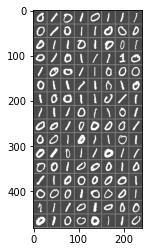

GroundTruth:      0     1     0     1     0     1     1     1     0     1     0     1     1     0     0     0     0     1     1     0     1     0     0     1     0
Predicted:      0     1     0     1     0     1     1     1     0     1     0     1     1     0     0     0     0     1     1     0     1     0     0     1     0


In [8]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, show_labels = dataiter.next()
images, show_labels = images.to(try_gpu()), show_labels.to(try_gpu())

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[show_labels[j]] for j in range(25)))

outputs = classifiernet(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(25)))

Predicted: 0  Probability: 1.0


/mnt/f/miniconda3/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/mnt/f/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Predicted: 1  Probability: 1.0


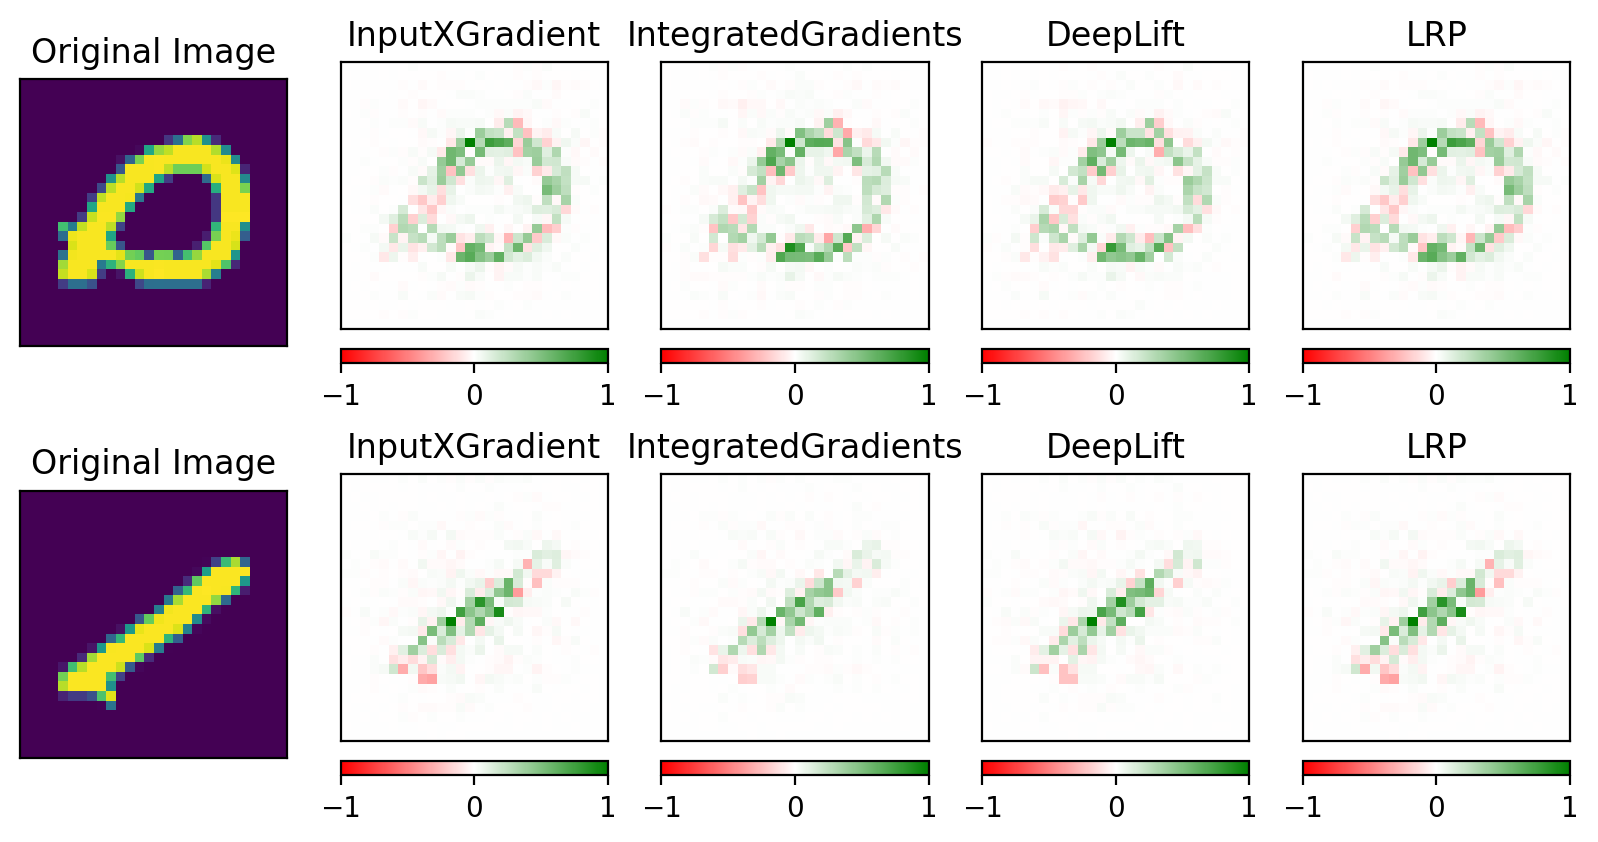

In [9]:
def attribute_image_features(net, algorithm, input, label, **kwargs):
    net.zero_grad()
    return algorithm.attribute(input, target=label, **kwargs)

fig, axs = plt.subplots(2, 5, figsize=(10, 5), dpi=200)

ind = [0, 1]
titles = ["InputXGradient", "IntegratedGradients", "DeepLift", "LRP", "Original Image"]
methods = [InputXGradient, IntegratedGradients, DeepLift, LRP, None]
classifiernet.eval()
for j, index in enumerate(ind):
    input = images[index].unsqueeze(0)
    input.requires_grad = True
    label = show_labels[index]
    original_image = np.transpose((images[index].cpu().detach().numpy() / 2) + 0.5)
    print('Predicted:', classes[predicted[index]], 
      ' Probability:', torch.max(torch.nn.functional.softmax(outputs, 1)).item())
    for i, method in enumerate(methods):
        if i < 4:
            img_attr = method(classifiernet)
            show_attr = attribute_image_features(classifiernet, img_attr, input, label)
            show_attr = np.transpose(show_attr.squeeze().cpu().detach().numpy()).reshape((28,28,1))
            _ = viz.visualize_image_attr(
                show_attr,
                original_image,
                method='heat_map',
                show_colorbar=True,
                sign='all',
                outlier_perc=1,
                title=titles[i],
                plt_fig_axis=(fig, axs[j, i+1]),
                use_pyplot=False,
            )
        else:
            _ = viz.visualize_image_attr(
                None, original_image, 
                method="original_image", title=titles[i],
                plt_fig_axis=(fig, axs[j, 0]),
                use_pyplot=False,
            )
        
# fig.savefig("result.eps", bbox_inches="tight")
plt.show()

In [12]:
from scipy import stats

# stats.spearmanr( [5,6,7,8,7],[1,2,3,4,5])
# SpearmanrResult(correlation=0.82078..., pvalue=0.08858...)

test_loader_spearman = torch.utils.data.DataLoader(testset, batch_size=1, sampler=SubsetRandomSampler(sub_testset_indices), 
                                        num_workers=8, pin_memory=True)

classifiernet_cpu = classifiernet.cpu()
classifiernet_cpu.eval()
for i, method1 in enumerate(methods[:-1]):
    for j, method2 in enumerate(methods[i:-1]):
        rho_total = 0.0
        for k, (inputs, labels) in enumerate(test_loader_spearman, 0):
            # print(inputs.shape, labels.shape)
            input = inputs[0].unsqueeze(0)
            # print(inputs.shape)
            input.requires_grad = True
            label = labels      
            spear_attr_method1 = method1(classifiernet_cpu)
            spear_attr_method2 = method2(classifiernet_cpu)
            compute_attr1 = attribute_image_features(classifiernet_cpu, spear_attr_method1, input, label).detach().numpy().reshape((28*28))
            # compute_attr1 = np.transpose(compute_attr1.squeeze().detach().numpy()).reshape((28*28))
            compute_attr2 = attribute_image_features(classifiernet_cpu, spear_attr_method2, input, label).detach().numpy().reshape((28*28))
            # compute_attr2 = np.transpose(compute_attr2.squeeze().detach().numpy()).reshape((28*28))
            rho, _ = stats.spearmanr(compute_attr1, compute_attr2)
            rho_total += rho
        print(f"size:[{k+1}] and {titles[i]} X {titles[i+j]} : ", rho_total / (k+1))

size:[2115] and InputXGradient X InputXGradient :  1.0
size:[2115] and InputXGradient X IntegratedGradients :  0.8619809787966037


/mnt/f/miniconda3/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/mnt/f/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


size:[2115] and InputXGradient X DeepLift :  0.8397460837700094
size:[2115] and InputXGradient X LRP :  0.9999999993493978
size:[2115] and IntegratedGradients X IntegratedGradients :  1.0
size:[2115] and IntegratedGradients X DeepLift :  0.8823421696294994
size:[2115] and IntegratedGradients X LRP :  0.8619809823192413
size:[2115] and DeepLift X DeepLift :  1.0
size:[2115] and DeepLift X LRP :  0.8397461087545138
size:[2115] and LRP X LRP :  1.0
